# Overview

This notebook walks through two variants of a RL agent that uses a deep Q-network with different tricks to solve the Unity banana-collection environment.  The version demonstrated are as follows:

1. Base learner: a very basic Q-learner with a single-layer network
2. Advanced learner: a Double Deep Q-learer that includes several optimization tricks (notably Replay Prioritization and Multi-Step Learning)

Each learner is tested with a small Q-network (1x64 hidden layers) and a larger Q-network(4x64 hidden layers).

While there is no strict definition of solving the banana-gathering task, for the purposes of this experiment, we will consider any agent that has averaged an average reward of 13 or higher for at least 100 episodes to have solved the environment.  (For reference, the highest acheivable 100-episode average seems to be a little over 16.)

Under this definition, with nearly-optimal hyperparameters, the advanced learner can consistently solve this environment in 250 episodes.

*Note: the required Banana.app package is configured for mac only.*

# Setup

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Basic Description of the State and Action Spaces

*Description below taken from Udacity's Deep Reinforcement Learning course*

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


# 1. base learner

The base learner is a very basic implementation of Q-learning. The few "tricks" it is equipped with are:

**memory replay:** the learner stores state-action-reward tuples and randomly samples them to learn

**separate actor and evaluator networks (double DQN):** the learner has a separate network for choosing actions (the actor network) and estimating the value of the next state (the evaluator network for calculating the target value).  However, the networks are not trained separately – the evaluator's weights are soft-updated from the weights of the actor network – so this is a very simple form of a DDQN.

**epsilon decay:** the learner starts with a high epsilon, and decays gradually to a low epsilon

## small network

Average episodes to solve environment: 549 



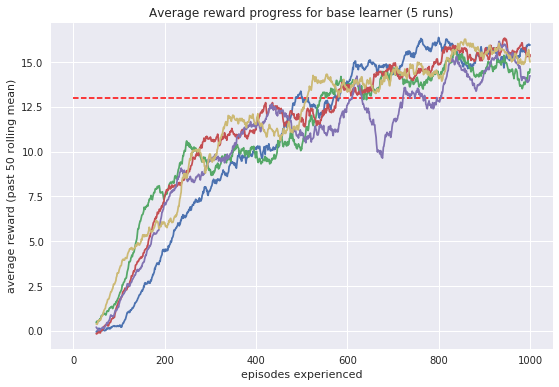

In [17]:
%%time
import sys
import pickle
sys.path.append('./base_learner/')
from base_agent import Agent
from base_training_loop import train_agent

score_sets = []

for seed in range(5):
    print('trial', seed, 'begun...')
    env_info = env.reset(train_mode=True)[brain_name]
    agent = Agent(
        state_size=37, 
        action_size=4, 
        seed=seed, 
        fcn_sizes=[64]
    )
    scores = train_agent(
        env=env,
        brain_name=brain_name,
        agent=agent,
        n_episodes=1000, 
        max_t=1000, 
        eps_end=0.01, 
        eps_decay=0.99,
        train_every_n=10,
        verbose=False
    )
    # log scores from this run
    with open("base_test_small_{}.pickle".format(seed), "wb") as output_file:
        pickle.dump(scores, output_file)
    score_sets.append(scores)
    print('trial', seed, 'completed')

# log mean score for each episode    
mean_scores = list(np.array(score_sets).mean(axis=0))
with open("base_test_small_mean.pickle", "wb") as output_file:
    pickle.dump(mean_scores, output_file)
    
# plot results
smoothed_scores = np.convolve(mean_scores, np.ones(100)/100, 'valid')
episode_num = np.argwhere(smoothed_scores >= 13)[0][0] + 50
print('Average episodes to solve environment:', episode_num, '\n')
sns.set()
plt.figure(figsize=(9,6))
plt.hlines(y=13, xmin=0, xmax=len(mean_scores), colors='red', 
           linestyles='--', lw=1.5, label='target threshold')
for i, s in enumerate(score_sets):
    smoothed_scores = np.convolve(s, np.ones(50)/50, 'valid')
    plt.plot(range(50, len(smoothed_scores)+50), smoothed_scores, 
             label='run_'+str(i))
plt.xlabel('episodes experienced')
plt.ylabel('average reward (past 50 rolling mean)')
plt.title('Average reward progress for base learner (5 runs)')
plt.show()

## large network
With a bigger network (four hidden layers instead of one), the base learner actually performs slightly worse.

trial 0 begun...
trial 0 completed
trial 1 begun...
trial 1 completed
trial 2 begun...
trial 2 completed
trial 3 begun...
trial 3 completed
trial 4 begun...
trial 4 completed
Average episodes to solve environment: 572 



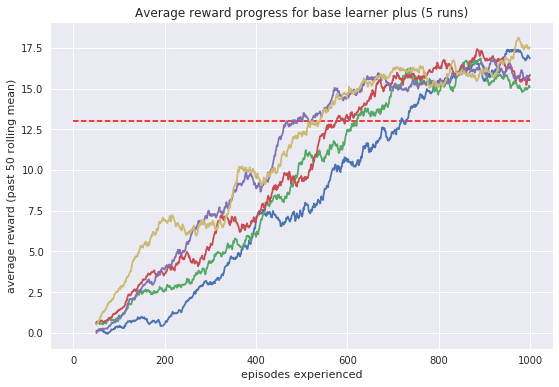

CPU times: user 35min 23s, sys: 3min 27s, total: 38min 50s
Wall time: 1h 7s


In [18]:
%%time
import sys
import pickle
sys.path.append('./base_learner/')
from base_agent import Agent
# from base_training_loop import train_agent

score_sets = []

for seed in range(5):
    print('trial', seed, 'begun...')
    env_info = env.reset(train_mode=True)[brain_name]
    agent = Agent(
        state_size=37, 
        action_size=4, 
        seed=seed, 
        fcn_sizes=[64,64,64,64]
    )
    scores = train_agent(
        env=env,
        brain_name=brain_name,
        agent=agent,
        n_episodes=1000, 
        max_t=1000, 
        eps_end=0.01, 
        eps_decay=0.988,
        train_every_n=10,
        verbose=False
    )
    # log scores from this run
    with open("base_test_plus_{}.pickle".format(seed), "wb") as output_file:
        pickle.dump(scores, output_file)
    score_sets.append(scores)
    print('trial', seed, 'completed')

# log mean score for each episode    
mean_scores = list(np.array(score_sets).mean(axis=0))
with open("base_test_plus_mean.pickle", "wb") as output_file:
    pickle.dump(mean_scores, output_file)
    
# plot results
smoothed_scores = np.convolve(mean_scores, np.ones(100)/100, 'valid')
episode_num = np.argwhere(smoothed_scores >= 13)[0][0] + 50
print('Average episodes to solve environment:', episode_num, '\n')
sns.set()
plt.figure(figsize=(9,6))
plt.hlines(y=13, xmin=0, xmax=len(mean_scores), colors='red', 
           linestyles='--', lw=1.5, label='target threshold')
for i, s in enumerate(score_sets):
    smoothed_scores = np.convolve(s, np.ones(50)/50, 'valid')
    plt.plot(range(50, len(smoothed_scores)+50), smoothed_scores, 
             label='run_'+str(i))
plt.xlabel('episodes experienced')
plt.ylabel('average reward (past 50 rolling mean)')
plt.title('Average reward progress for base learner plus (5 runs)')
plt.show()

# 3. Advanced learner

This Q-learning agent is equipped with several additional tricks for faster learning.  In addition to the epsilon decay and memory replay used in the base learner, it implements the following:

**double DQN** (citation): as in the base learner, the agent has two separate networks – one for choosing actions, and another for evaluating them.  However, in this version, the models are trained separately on different random samples from the memory replay, which ensures they won't have any interdependencies that could lead to harmful feedback loops.

**prioritized replay** (citation): to learn, the agent selects randomly from its stored experiences.  However, the experiences are weighted by model error, so that the agent is more likely to pick experiences that it has more to learn from.  To ensure that new (never-learned-on) experiences get a priority bump, the first-time error is multiplied by 2.

**multi-step Q-learning** (citation): instead of the traditional Q-learning reward formula:
    
    total_reward = reward + gamma\*Q_evaluator(next_state)
    
total_reward is calculated using the discounted actual rewards of the next *n* timesteps:
    
    reward_0 + (gamma**1)*reward_1 + (gamma**2)**reward_2 ... + (gamma**n) * Q_evaluator(nth_state)
    

**NOTE**: as before, these hyperparameters have been chosen after dozens of tests in other notebooks.  (For example, while raising n_multistep to 8 resulted in a faster solution, raising all the way to 20 causes the learner to peak at an average reward at 6.)  Repeated trials with these optimal hyperparameters place the runs-required-to-solve in the 175-250 range

In [20]:
del Agent, train_agent
sys.path = sys.path[:-1]

## small network

Running on cpu 

trial 0 begun...
trial 0 completed
trial 1 begun...
trial 1 completed
trial 2 begun...
trial 2 completed
trial 3 begun...
trial 3 completed
trial 4 begun...
trial 4 completed
Average episodes to solve environment: 354 



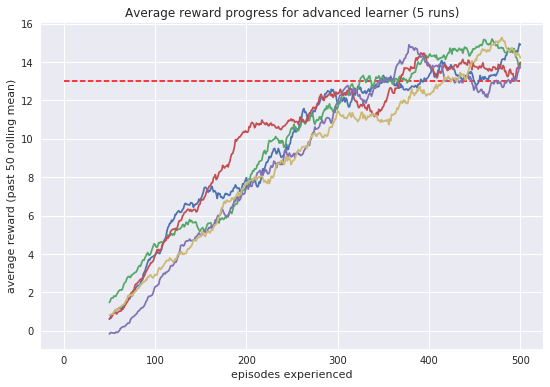

CPU times: user 1h 15min 54s, sys: 2min 15s, total: 1h 18min 10s
Wall time: 1h 28min 24s


In [5]:
%%time
import sys
import pickle
sys.path.append('./advanced_learner/')
from agent import Agent
# from training_loop import train_agent

score_sets = []

for seed in range(5):
    print('trial', seed, 'begun...')
    env_info = env.reset(train_mode=True)[brain_name]
    agent = Agent(
        state_size=37,
        action_size=4,
        replay_epsilon=0.5,
        seed=seed,
        n_multi_step=5,
        gamma=0.96,
        buffer_size=2e5,
        truncate_by_min_error=True, 
        fcn_sizes=[64]
    )
    scores = train_agent(
        env=env,
        brain_name=brain_name,
        agent=agent,
        n_episodes=500,
        max_t=1000,
        eps_end=0.01,
        eps_decay=0.98,
        train_every_n=10,
        double_dqn=True,
        verbose=False
    )
    # log scores from this run
    with open("advanced_test_small_{}.pickle".format(seed), "wb") as output_file:
        pickle.dump(scores, output_file)
    score_sets.append(scores)
    print('trial', seed, 'completed')

# log mean score for each episode    
mean_scores = list(np.array(score_sets).mean(axis=0))
with open("advanced_test_small_mean.pickle", "wb") as output_file:
    pickle.dump(mean_scores, output_file)
    
# plot results
smoothed_scores = np.convolve(mean_scores, np.ones(100)/100, 'valid')
episode_num = np.argwhere(smoothed_scores >= 13)[0][0] + 50
print('Average episodes to solve environment:', episode_num, '\n')
sns.set()
plt.figure(figsize=(9,6))
plt.hlines(y=13, xmin=0, xmax=len(mean_scores), colors='red', 
           linestyles='--', lw=1.5, label='target threshold')
for i, s in enumerate(score_sets):
    smoothed_scores = np.convolve(s, np.ones(50)/50, 'valid')
    plt.plot(range(50, len(smoothed_scores)+50), smoothed_scores, 
             label='run_'+str(i))
plt.xlabel('episodes experienced')
plt.ylabel('average reward (past 50 rolling mean)')
plt.title('Average reward progress for advanced learner (5 runs)')
plt.show()

## large network

NOTE: the trial run below whose score heavily drops off at the end is fairly anomalous; it's the only case I observed out of about 15 total runs with these parameters (though I did see this result a little more commonly with different, suboptimal parameters).

trial 0 begun...
trial 0 completed
trial 1 begun...
trial 1 completed
trial 2 begun...
trial 2 completed
trial 3 begun...
trial 3 completed
trial 4 begun...
trial 4 completed
Average episodes to solve environment: 245 



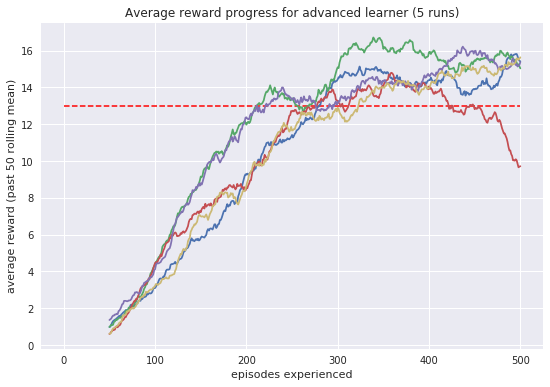

CPU times: user 1h 18min 30s, sys: 2min 1s, total: 1h 20min 32s
Wall time: 1h 30min 48s


In [6]:
%%time
import sys
import pickle
sys.path.append('./advanced_learner/')
from agent import Agent
# from training_loop import train_agent

score_sets = []

for seed in range(5):
    print('trial', seed, 'begun...')
    env_info = env.reset(train_mode=True)[brain_name]
    agent = Agent(
        state_size=37,
        action_size=4,
        replay_epsilon=0.5,
        seed=seed,
        n_multi_step=5,
        gamma=0.96,
        buffer_size=2e5,
        truncate_by_min_error=True, 
        fcn_sizes=[64,64,64,64]
    )
    scores = train_agent(
        env=env,
        brain_name=brain_name,
        agent=agent,
        n_episodes=500,
        max_t=1000,
        eps_end=0.01,
        eps_decay=0.982,
        train_every_n=10,
        double_dqn=True,
        verbose=False
    )
    # log scores from this run
    with open("advanced_test_final_{}.pickle".format(seed), "wb") as output_file:
        pickle.dump(scores, output_file)
    score_sets.append(scores)
    print('trial', seed, 'completed')

# log mean score for each episode    
mean_scores = list(np.array(score_sets).mean(axis=0))
with open("advanced_test_final_large_6.pickle", "wb") as output_file:
    pickle.dump(mean_scores, output_file)
    
# plot results
smoothed_scores = np.convolve(mean_scores, np.ones(100)/100, 'valid')
episode_num = np.argwhere(smoothed_scores >= 13)[0][0] + 50
print('Average episodes to solve environment:', episode_num, '\n')
sns.set()
plt.figure(figsize=(9,6))
plt.hlines(y=13, xmin=0, xmax=len(mean_scores), colors='red', 
           linestyles='--', lw=1.5, label='target threshold')
for i, s in enumerate(score_sets):
    smoothed_scores = np.convolve(s, np.ones(50)/50, 'valid')
    plt.plot(range(50, len(smoothed_scores)+50), smoothed_scores, 
             label='run_'+str(i))
plt.xlabel('episodes experienced')
plt.ylabel('average reward (past 50 rolling mean)')
plt.title('Average reward progress for advanced learner (5 runs)')
plt.show()

# Conclusions



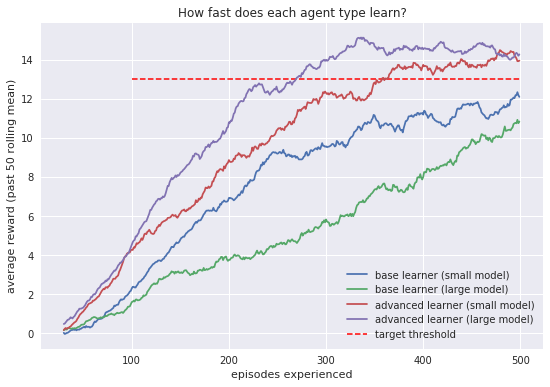

In [18]:
import pickle

labeled_fnames = [
    ('base learner (small model)', "base_test_small_mean.pickle"),
    ('base learner (large model)', "base_test_plus_mean.pickle"),
    ('advanced learner (small model)', "advanced_test_small_mean.pickle"),
    ('advanced learner (large model)',"advanced_test_final_large_6.pickle"),
]

sns.set()
plt.figure(figsize=(9,6))
plt.hlines(y=13, xmin=100, xmax=500, colors='red', 
           linestyles='--', lw=1.5, label='target threshold')

for label, fname in labeled_fnames:
    with open(fname, "rb") as file:
        scores = pickle.load(file)
    smoothed_scores = np.convolve(scores, np.ones(30)/30, 'valid')[:470]
    plt.plot(range(30, len(smoothed_scores)+30), smoothed_scores, 
             label=label)
    
plt.xlabel('episodes experienced')
plt.ylabel('average reward (past 50 rolling mean)')
plt.title('How fast does each agent type learn?')
plt.legend()
plt.show()

In this experiment, I've demonstrated that my advanced learner can solve Unity's banana-collection environment in about 250 steps.  As the plot above shows, the combination of prioritized replay, double DQN, and multi-step learning cut the learning time by approximately half, which is a large improvement.  This demonstrates the effectiveness of these techniques in combination.  

Additionally, a larger network (4x64 hidden layers) provided a significant boost to the advanced learner, but was actually detrimental to the base learner.

The primary caveat to these results is that they do require extensive hyperparameter tuning.  Each trick added to the agent introduces more hyperparameters, each of which multiplicatively increases the number of iterations required to optimize hyperparameters.  So while adding more of these tricks was hugely helpful for the learning speed, it drastically increased the meta-learning speed.  This tradeoff will not always be worth it in real-world use cases.

# Future Work

There are several other Q-learning tricks that I have not employed in the advanced learner.  Most notably, the Distributional DQN technique pioneered by Bellemare, Dabney, and Munos in 2017 has been shown to add further learning speed to combinations of other optimizing techniques like those used here (Hessel et al., 2017).  Implementing a distributional value estimation strategy could allow our advanced agent to learn even faster.

# Sources

Hessel et al., 2017.  "Rainbow: Combining Improvements in Deep Reinforcement Learning".  <https://arxiv.org/pdf/1710.02298.pdf>

Hasselt, Guez, & Silver, 2015.  "Deep Reinforcement Learning with Double Q-learning". <https://arxiv.org/pdf/1509.06461.pdf>

Schaul et al., 2016. "Prioritized Experience Replay". <https://arxiv.org/pdf/1511.05952.pdf>

Bellemare, Dabney, & Munos, 2017. "A Distributional Perspective on Reinforcement Learning". <https://arxiv.org/pdf/1707.06887.pdf>